# Density based clustering explained

Learn in this tutorial about the basics of density-based clustering and how common-nearest-neighbours
clustering works compared to other methods.

## Pre-requirements

### Import dependencies

In [1]:
from collections import deque
from itertools import islice
import sys

from IPython.display import HTML
import matplotlib as mpl
from matplotlib import animation
import matplotlib.pyplot as plt
# import networkx
import numpy as np
from scipy.integrate import quad
from scipy import stats
from scipy.spatial import cKDTree
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

This notebook was created using Python 3.8.

In [2]:
# Version information
print(sys.version)

3.8.5 | packaged by conda-forge | (default, Aug 21 2020, 18:21:27) 
[GCC 7.5.0]


In [4]:
# Matplotlib configuration
mpl.rc_file(
    "../matplotlibrc",
    use_default_template=False
)

### Helper functions

In [5]:
def gauss(x, sigma, mu):
    """Gaussian PDF"""
    return (1 / (sigma * np.sqrt(2 * np.pi))
            * np.exp(-1 / 2 * ((x - mu) / sigma)**2))
    
def multigauss(x, sigma, mu):
    """Multimodal gaussian PDF as linear combination of gaussian PDFs"""
    assert len(sigma) == len(mu)
    
    out = np.zeros_like(x)
    for s, m in zip(sigma, mu):
        out += gauss(x, s, m)
    return out / len(sigma)

In [6]:
def determine_cuts(x, a, cutoff):
    """Find points in space where density cutoff is crossed
    
    Args:
       x: coordinate
       a: density
       cutoff: density cutoff
    
    Returns:
       cuts: Array of coordinates where cutoff is crossed
    """
    
    cuts = []
    dense = False  # Assume low density on left border
    for index, value in enumerate(a[1:], 1):
        if dense:
            if value < cutoff:
                dense = False
                cuts.append((x[index] + x[index - 1]) / 2)        
        else:
            if value >= cutoff:
                dense = True
                cuts.append((x[index] + x[index - 1]) / 2)
    
    return np.asarray(cuts)

In [7]:
class multigauss_distribution(stats.rv_continuous):
    """Draw samples from a multimodal gaussian distribution"""
           
    def __init__(self, sigma, mu, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._sigma = sigma
        self._mu = mu

    def _pdf(self, x):
        return multigauss(x, sigma=self._sigma, mu=self._mu)

## Density criteria

Density-based clustering defines clusters as *dense* regions in space, separated by *sparse* regions. But what is dense and what is sparse? This is commonly defined by a threshold, that is a density criterion that determines the clustering. In the case where we have a density function defined on a continuous coordinate, the density criterion manifests itself as a density iso-surface. Regions in which the density is higher than a cutoff set as density criterion qualify as *dense*, and therefore represent a cluster. On the other hand, regions in which the density falls below the density criterion are considered *sparse* and do not constitute a part of a cluster. We can illustrate this on the example of a bimodal gaussian distribution in one dimension.

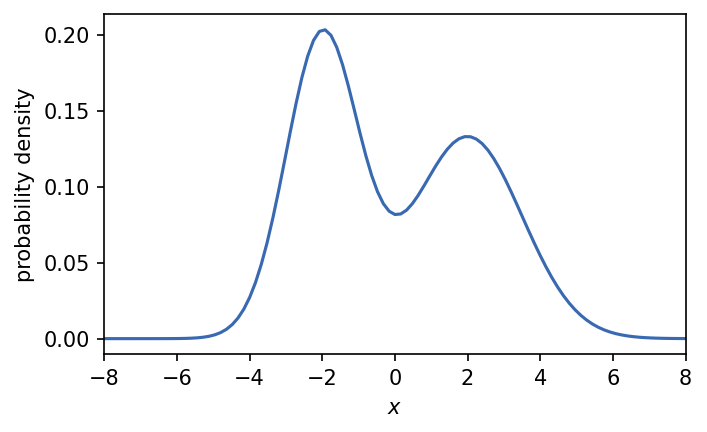

In [19]:
xlimit = (-8, 8)
x = np.linspace(*xlimit, 101)

fig, ax = plt.subplots()
ax.plot(x, multigauss(x, sigma=[1, 1.5], mu=[-2, 2]))
ax.set(**{
    "xlim": xlimit,
    "xlabel": "$x$",
    "ylabel": "probability density"
})
plt.show()

We have two maxima in the distribution. An intuitive classification in clusters
would separate the two peaks into two different clusters. In density based clustering we define the two clusters as the regions of high density where we have low density in between. By applying an iso-value cutoff on the density, we can specify what should be considered high or low density. In a dense region, the density is at least as high as the density criterion requires.

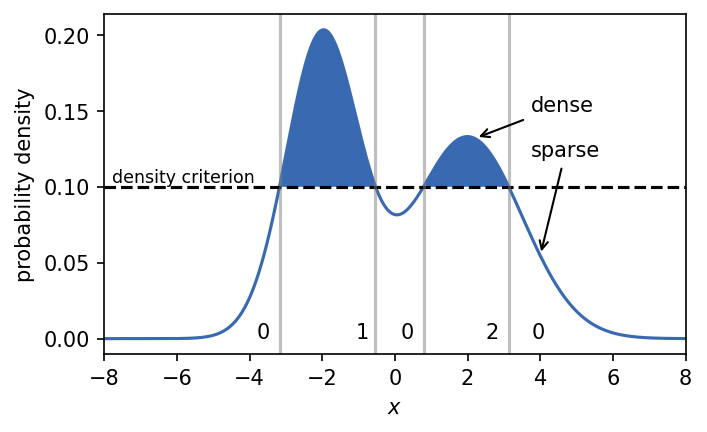

In [43]:
density_criterion = 0.1

xlimit = (-8, 8)
x = np.linspace(*xlimit, 1001)
pdf = multigauss(x, sigma=[1, 1.5], mu=[-2, 2])
cuts = determine_cuts(x, pdf, density_criterion)
density_criterion_ = np.full_like(x, density_criterion)
dense = np.maximum(pdf, density_criterion_)

fig, ax = plt.subplots()
ax.plot(x, pdf)
ax.plot(x, density_criterion_, linestyle="--", color="k")
ax.fill_between(x, density_criterion_, dense)
for cut in cuts:
    ax.axvline(cut, color="gray", alpha=0.5)

ax.annotate(
    "density criterion", (xlimit[0] * 0.975, density_criterion * 1.03),
    fontsize="small"
)

ax.annotate("0", (cuts[0] * 1.2, 0))
ax.annotate("1", (cuts[1] * 2, 0))
ax.annotate("0", (cuts[2] * 0.2, 0))
ax.annotate("2", (cuts[3] * 0.8, 0))
ax.annotate("0", (cuts[3] * 1.2, 0))

ax.annotate(
    "dense",
    xy=(2.2, multigauss(2.2, sigma=[1, 1.5], mu=[-2, 2])),
    xytext=(cuts[3] * 1.2, density_criterion * 1.5),
    arrowprops={"arrowstyle": "->"}
)

ax.annotate(
    "sparse",
    xy=(4, multigauss(4., sigma=[1, 1.5], mu=[-2, 2])),
    xytext=(cuts[3] * 1.2, density_criterion * 1.2),
    arrowprops={"arrowstyle": "->"}
)

ax.set(**{
    "xlim": xlimit,
    "xlabel": "$x$",
    "ylabel": "probability density"
})
plt.show()

Choosing the density criterion in this way, defines the two clusters exactly as we would have expected. We can label the regions, i.e. we can assign a number to them, that denotes their cluster membership. We use 0 to indicate that a region is not part of any cluster and positive integers as cluster numbers. When we vary the density criterion, we can influence the outcome of the clustering by changing the definition of what is dense enough to be a cluster. This could leave us with both density maxima in one cluster, clusters of different broadness, or not cluster at all.

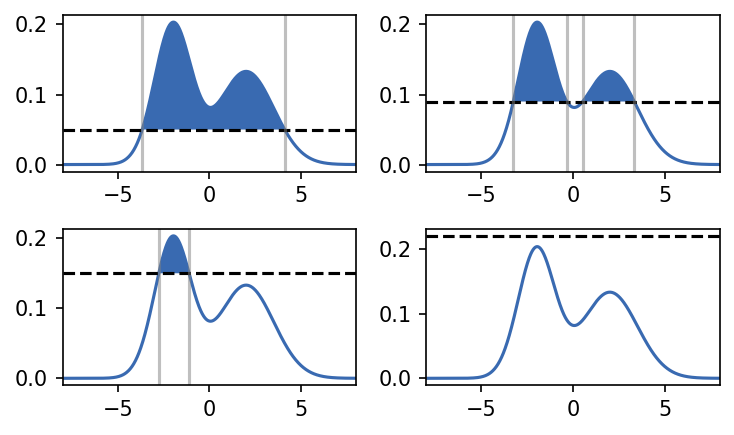

In [53]:
fig, Ax = plt.subplots(2, 2)
ax = Ax.flatten()

for i, d in enumerate([0.05, 0.09, 0.15, 0.22]):
    density_criterion = d

    xlimit = (-8, 8)
    x = np.linspace(*xlimit, 1001)
    pdf = multigauss(x, sigma=[1, 1.5], mu=[-2, 2])
    cuts = determine_cuts(x, pdf, density_criterion)
    density_criterion_ = np.full_like(x, density_criterion)
    dense = np.maximum(pdf, density_criterion_)


    ax[i].plot(x, pdf)
    ax[i].plot(x, density_criterion_, linestyle="--", color="k")
    ax[i].fill_between(x, density_criterion_, dense)
    for cut in cuts:
        ax[i].axvline(cut, color="gray", alpha=0.5)


    ax[i].set(**{
        "xlim": xlimit,
    })
    
fig.tight_layout()
plt.show()

When we operate on data sets (in maybe high dimensional spaces), however, we normally do not have a continuous description of the density, that we can directly use. Instead we may have sample points from an underlying (unknown) distribution. To apply a density based clustering on them, we need to approximate the density in some way. For this approximation, quite a number of different possibilities exist, which provide a different notion of what density is or how it could be estimated from scattered data. To illustrate this, let's draw samples from the above used bimodal distribution to emulate data points.

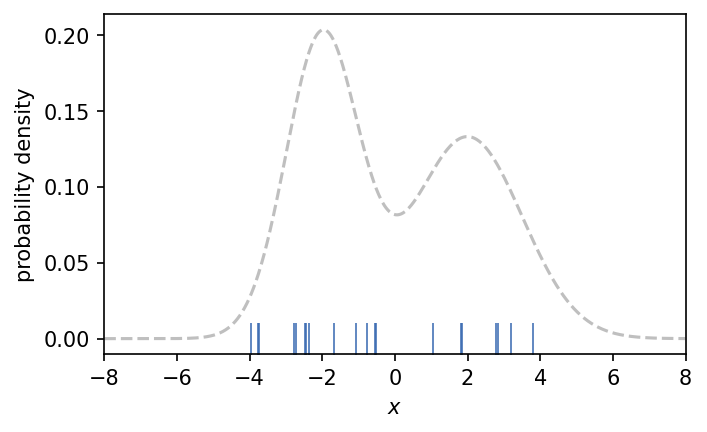

In [172]:
distribution = multigauss_distribution(
    sigma=[1, 1.5], mu=[-2, 2], a=-8, b=8, seed=11
)
samples = distribution.rvs(size=20)

xlimit = (-8, 8)
x = np.linspace(*xlimit, 1001)
pdf = multigauss(x, sigma=[1, 1.5], mu=[-2, 2])

fig, ax = plt.subplots()
ax.plot(x, pdf, color="gray", linestyle="--", alpha=0.5)

ax.set(**{
    "xlim": xlimit,
    "xlabel": "$x$",
    "ylabel": "probability density"
})

ax.plot(samples, np.zeros_like(samples), linestyle="",
        marker="|", markeredgewidth=0.75, markersize=15) 

plt.show()

In the following we look into how density is deduced from points in terms of the following methods:
    
  - DBSCAN
  - Jarvis-Patrick
  - CNN
  
In general, point density can be expressed in simple terms by the number of points $n$ found on an area $x$ $\left(\rho = \frac{n}{x}\right)$.

### DBSCAN

In DBSCAN local point density (so the density around a sample point) is accordingly expressed as the number of neighbouring points $k_r$ with respect to a neighbour search radius $r$.
The density criterion is formulated as such: Points that have at least $k$ nearest neighbours in their neighbourhood $r$ qualify as part of a dense region, i.e. a cluster. Points that fulfill the density criterion can be also referred to as *core points*. Additionally it is possible to describe points that do not fulfill the density criterion themselves but are neighbours of those core points as *edge points*. For our samples above this could look as the followed if we choose the density criterion as $k=1$ and $r=0.5$. To determine the number of neighbours for each point, we calculated pairwise point distances and compare them to $r$.

In [179]:
# Density criterion
r = 0.5  # Neighbour search radius
k = 1    # Minimum number of neighbours

n_neighbours = np.array([
    # Neighbour within r?
    len(np.where((0 < x) & (x <= r))[0])
    # distance matrix
    for x in np.absolute(np.subtract.outer(samples, samples))
])

dense = n_neighbours >= k  # Point is part of dense region?
dense

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True])

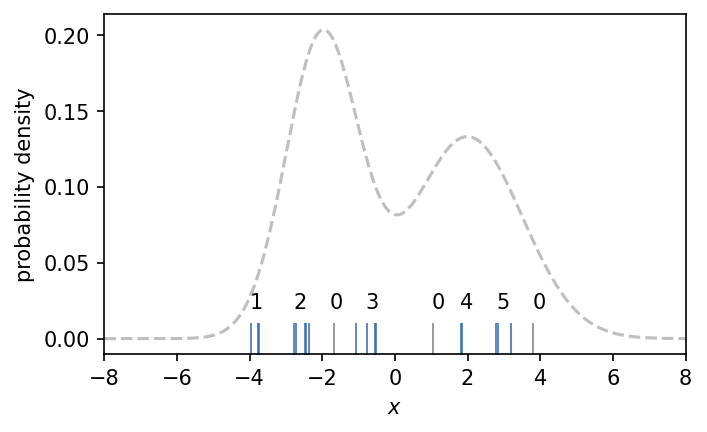

In [180]:
xlimit = (-8, 8)
x = np.linspace(*xlimit, 1001)
pdf = multigauss(x, sigma=[1, 1.5], mu=[-2, 2])

fig, ax = plt.subplots()
ax.plot(x, pdf, color="gray", linestyle="--", alpha=0.5)

ax.set(**{
    "xlim": xlimit,
    "xlabel": "$x$",
    "ylabel": "probability density"
})

for i, s in enumerate(samples):
    if dense[i]:
        c = "#396ab1"
    else:
        c = "gray"
    ax.plot(s, 0, linestyle="",
            marker="|", markeredgewidth=0.75, markersize=15,
            color=c)

labels = [
    (-4, "1"),
    (-2.8, "2"),
    (-1.8, "0"),
    (-0.8, "3"),
    (1, "0"),
    (1.8, "4"),
    (2.8, "5"),
    (3.8, "0"),
]

for position, l in labels:
    ax.annotate(l, (position, 0.02))

plt.show()

In this case we end up with 5 clusters, that are dense enough regions separated by low density areas. Like a change in the density iso-value as the density criterion for the continuous density function, a change of the cluster parameters $k$ and $r$ will determine the cluster result. Note, that we assigned the labels to the clusters by visual inspection. We will show later how to identify these isolated regions (connected components of core points) automatically.

### Jarvis-Patrick

In [ ]:
### CNN

### Summary on density criteria

A point is part of a dense region if the point ...

  - DBSCAN: ... has at least $k_r$ neighbours within a radius $r$
  - Jarvis-Patrick: ... shares at least $c$ common neighbours with a another point among their $k$ nearest neighbours
  - CNN: ... shares at least $c$ common neighbours with a another point with respect to a radius $r$

## Identify connected components of points

Classifying points as part of a dense or a sparse region according to a density criterion, is only one aspect of assigning points to clusters. We still need to identify groups of points that are part of the same region. In this context, we use the term *density reachable* to describe the situation where point is directly connected to a dense point. We also use the term *density connected* for points that are part of the same dense region, i.e. they are directly or indirectly connected to any other point in the region by a chain of density reachable points. In other words, it is not enough to know which points are dense but we also need to be aware of the relationship between dense points. When we express this relationship in a graph, the problem of identifying clusters of density connected points comes down to finding connected components of nodes within this graph. For the methods we considered above, points are density reachable if they are neighbours of a dense point (with respect to a radius *r* or one of the $k$ nearest neighbours). In the above example, we where only interested in the information if a point was part of a dense region by checking the density criterion. Let's now construct a density graph instead in which each dense point constitutes a node and each vertex represent the density reachability between two points. We neglect the concept of edge points (points that are not dense but density reachable from a dense point) for the sake of simplicity here.

### DBSCAN

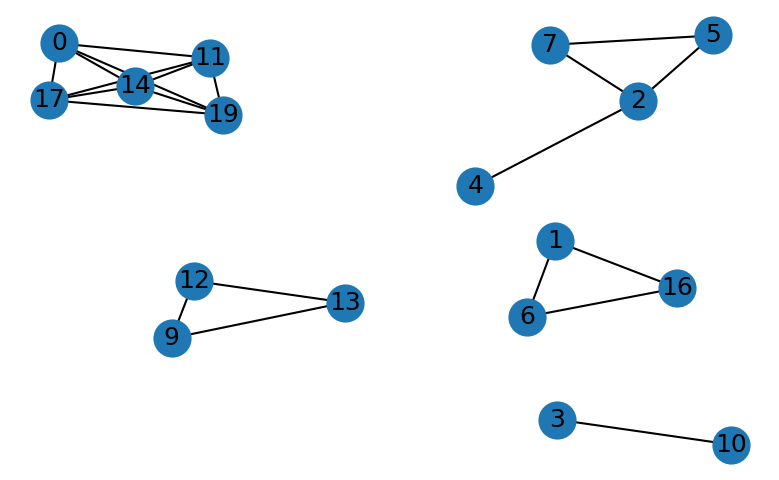

In [240]:
# Density criterion
r = 0.5  # Neighbour search radius
k = 1    # Minimum number of neighbours

neighbourhoods = [
    # Neighbour within r?
    np.where((0 < x) & (x <= r))[0]
    # distance matrix
    for x in np.absolute(np.subtract.outer(samples, samples))
]

n_neighbours = np.asarray([len(x) for x in neighbourhoods])
dense = n_neighbours >= k

# Construct graph as dictionary
# keys: dense points, values: density reachable points
graph = {}
for i, point in enumerate(neighbourhoods):
    if dense[i]:
        graph[i] = neighbourhoods[i][dense[neighbourhoods[i]]]

G = networkx.Graph(graph)
pos = networkx.spring_layout(G, iterations=10, seed=7)
networkx.draw(G, pos=pos, with_labels=True)
plt.show()

Once such a graph is constructed, graph traversal algorithms can be used to find the connected components of nodes within the graph. A generic way to do so using a breadth-first-search algorithm could look like this:

In [250]:
labels = {}                          # Cluster label assignments
visited = {k: False for k in graph}  # Node has been assigned
queue = deque()                      # First-in-first-out queue
current = 1                          # Current cluster number

for point, connected in graph.items():
    # Source node
    if visited[point]:
        continue
    
    labels[point] = current
    visited[point] = True
    
    while True:
        for reachable in connected:
            if visited[reachable]:
                continue
        
            labels[reachable] = current
            visited[reachable] = True
            queue.append(reachable)
        
        if not queue:
            break
            
        point = queue.popleft()
        connected = graph[point]
    
    current += 1

In [251]:
labels

{0: 1,
 11: 1,
 14: 1,
 17: 1,
 19: 1,
 1: 2,
 6: 2,
 16: 2,
 2: 3,
 4: 3,
 5: 3,
 7: 3,
 3: 4,
 10: 4,
 9: 5,
 12: 5,
 13: 5}

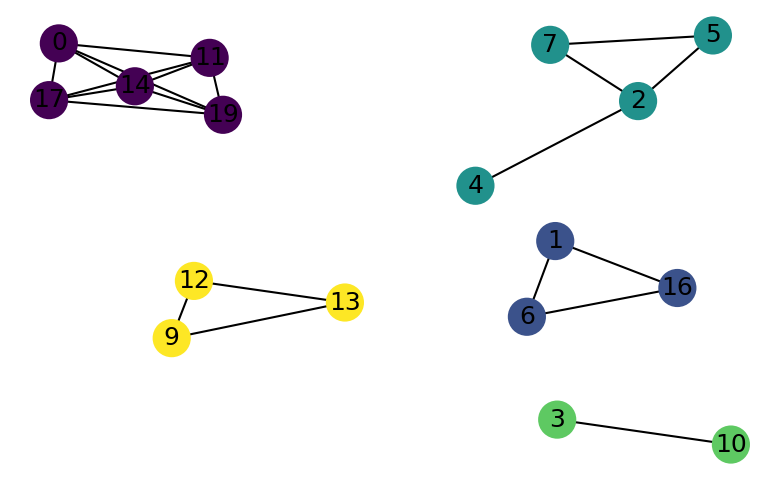

In [259]:
networkx.draw(G, pos=pos, with_labels=True, node_color=[x[1] for x in sorted(labels.items())])
plt.show()

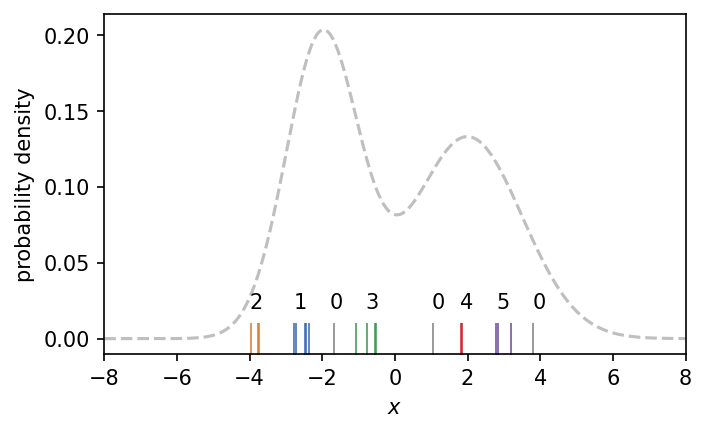

In [267]:
xlimit = (-8, 8)
x = np.linspace(*xlimit, 1001)
pdf = multigauss(x, sigma=[1, 1.5], mu=[-2, 2])

fig, ax = plt.subplots()
ax.plot(x, pdf, color="gray", linestyle="--", alpha=0.5)

ax.set(**{
    "xlim": xlimit,
    "xlabel": "$x$",
    "ylabel": "probability density"
})

colors = ['#396ab1', '#da7c30', '#3e9651', '#cc2529', '#6b4c9a']
for i, s in enumerate(samples):
    if dense[i]:
        c = colors[labels[i] - 1]
    else:
        c = "gray"
    ax.plot(s, 0, linestyle="",
            marker="|", markeredgewidth=0.75, markersize=15,
            color=c)

labels_ = [
    (-4, "2"),
    (-2.8, "1"),
    (-1.8, "0"),
    (-0.8, "3"),
    (1, "0"),
    (1.8, "4"),
    (2.8, "5"),
    (3.8, "0"),
]

for position, l in labels_:
    ax.annotate(l, (position, 0.02))

plt.show()

## CNN clustering in detail

<div class="alert alert-info">

**Note:** This section is currently under developement.

</div>

In practice, one does not necessarily need to construct a density connectivity graph in its entirety beforehand. It is also possible to start from another input structure and explore the connectivity while traversing the structure. We will now show a variant of the CNN clustering procedure, starting from pre-computed neighbourhoods in more detail. For this, we generate a small example data set of 200 points in 2D.

[[], [], None]

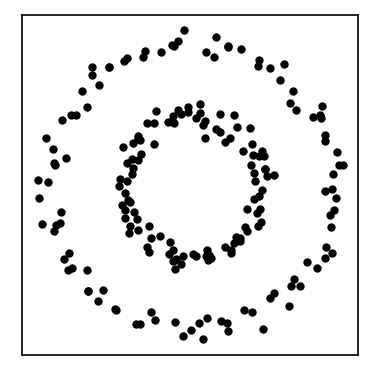

In [13]:
noisy_circles, _ = datasets.make_circles(
    n_samples=200,
    factor=.5,
    noise=.05,
    random_state=8
    )

noisy_circles = StandardScaler().fit_transform(noisy_circles)

fig, ax = plt.subplots()
ax.plot(*noisy_circles.T, "k.")
ax.set(**{
    "xticks": (),
    "yticks": (),
    "aspect": "equal"
})

We expect to find two clusters (an inner and an outer ring) in this data set. We will at first compute the neighbourhoods for all points with respect to a radius of $r$. Below we show the neighbourhood for the first point in the set.

In [15]:
r = 0.7

In [8]:
def point_zoom(data, point, ax):
    ax.plot(*data.T, "k.")
    ax.plot(*data[point].T, "r.")
    
    neighbourhood = mpl.patches.Circle(
        data[point], r,
        edgecolor="k",
        facecolor="grey"
    )
    ax.add_patch(neighbourhood)
    
    limit_factor = 1.2
    ax.set_xlim(data[point][0] - r * limit_factor,
                data[point][0] + r * limit_factor)
    ax.set_ylim(data[point][1] - r * limit_factor,
                data[point][1] + r * limit_factor)
    ax.set(**{
        "xticks": (),
        "yticks": (),
        "aspect": "equal"
    })

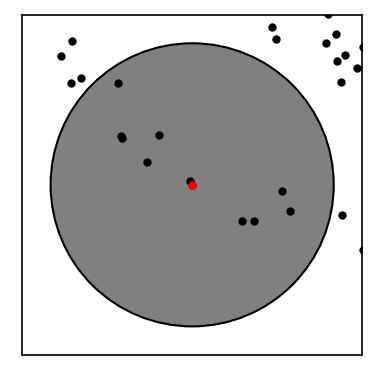

In [7]:
fig, ax = plt.subplots()
point_zoom(noisy_circles, 0, ax=ax)

In [16]:
# Calculate neighbourhoods using a k-d tree
tree = cKDTree(noisy_circles)
neighbourhoods = [set(x) for x in tree.query_ball_point(noisy_circles, r)]
for i, s in enumerate(neighbourhoods):
    # Avoid neighbour self-counting
    s.remove(i)

In [17]:
def check_similarity(a, b, c):
    """Check the CNN density criterion"""
    if len(a & b) >= c:
        return True
    return False

def cnn_from_neighbourhoods(
        neighbourhoods, c, yield_iterations=False):
    """Apply CNN clustering
    
    neighbourhoods:
        list of sets of point indices
        (neighbours of each point)
    c:
        Density reachable points need at least this many common
        nearest neighbours
    yield_iterations:
        Report state of clustering after each label assignment
    """
    
    n = len(neighbourhoods)              # Number of points
    visited = [False for _ in range(n)]  # Track visited
    labels = [0 for _ in range(n)]       # Output container
    queue = deque()                      # FIFO queue    
    current = 1                          # Cluster count
    
    for point in range(n):
        # Source node
        if visited[point]:
            continue
        
        visited[point] = True

        neighbours = neighbourhoods[point]
        if len(neighbours) <= c:
            continue

        labels[point] = current

        if yield_iterations:
            # Get current state of clustering
            yield (point, None, current, labels, visited)

        while True:
            for member in neighbours:
                if visited[member]:
                    continue
                    
                neighbour_neighbours = neighbourhoods[member]
                if len(neighbour_neighbours) <= c:
                    continue
                    
                if check_similarity(neighbours, neighbour_neighbours, c):
                    labels[member] = current
                    visited[member] = True
                    queue.append(member)
                    
                    if yield_iterations:
                        # Get current state of clustering
                        yield (point, member, current, labels, visited)

            if not queue:
                break

            point = queue.popleft()
            neighbours = neighbourhoods[point]

        current += 1
    
    if not yield_iterations:
        yield labels

In [18]:
def plt_iteration(
        data, iteration=None, ax=None, ax_props=None, color_list=None):

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        
    ax_props_defaults = {
        "xticks": (),
        "yticks": (),
        "aspect": "equal"
    }
    
    if ax_props is not None:
        ax_props_defaults.update(ax_props)
    
    if iteration is not None:
        point, member, current, labels, visited = iteration
        
        if color_list is None:
            color_list = [
                "black"] + [i["color"]
                            for i in islice(mpl.rcParams["axes.prop_cycle"],
                                            current)]

        for cluster in range(current + 1):
            indices = np.where(np.asarray(labels) == cluster)[0]
            ax.plot(*data[indices].T, c=color_list[cluster],
                    linestyle="", marker=".")
        
    else:
        ax.plot(*data.T)    
        
    ax.set(**ax_props_defaults)

In [24]:
class AnimatedIterations:
    """An animated scatter plot using matplotlib.animations.FuncAnimation."""
    def __init__(self, data, iterations=None):
        self.data = data
        self.iterations = iter(iterations)
        self.highlights = deque(maxlen=5)
        self.sizes = np.ones(len(self.data)) * 10

        self.fig, self.ax = plt.subplots()
        self.animation = animation.FuncAnimation(
            self.fig, self.update, frames=200, interval=100,
            init_func=self.setup_plot, blit=True
            )

    def setup_plot(self):
        """Initial drawing of the scatter plot."""
        self.scatter = self.ax.scatter(
            *self.data.T,
            s=self.sizes,
            c=np.asarray([0 for _ in range(len(self.data))]),
            cmap=mpl.colors.LinearSegmentedColormap.from_list(
                "cluster_map",
                ["black"] + [i["color"]
                             for i in islice(mpl.rcParams["axes.prop_cycle"],
                                             2)]
                ),
            vmin=0, vmax=2
            )
        # self.ax.axis([-10, 10, -10, 10])
        # For FuncAnimation's sake, we need to return the artist we'll be using
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scatter,

    def update(self, i):
        """Update the scatter plot."""
        point, member, current, labels, visited = next(self.iterations)
        if member is None:
            self.highlights.append(point)
        else:
            self.highlights.append(member)
            
        for c, p in enumerate(self.highlights, 1):
            self.sizes[p] = c * 10
        
        # Set sizes
        self.scatter.set_sizes(self.sizes)
        
        # Set colors
        self.scatter.set_array(np.asarray(labels))

        # We need to return the updated artist for FuncAnimation to draw..
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scatter,


Animation = AnimatedIterations(noisy_circles, cnn_from_neighbourhoods(neighbourhoods, 5, yield_iterations=True))
# Animation.animation.save('iteration.mp4', dpi=150)
plt.close()

In [25]:
Animation.animation.save('iteration.mp4', dpi=300)

In [23]:
HTML(Animation.animation.to_html5_video())